In [1]:
import pandas as pd
import numpy as np

import re
from text_helper import word_splitter, sentence_count, stop_word_counter, punc_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

rs = 91923 

In [2]:
df = pd.read_csv('../data/data_final.csv')

df['response_cleaned'] = df['response'].apply(lambda x: re.sub('[\\n]{2,}', '\n', x))
df['response_cleaned'] = df['response_cleaned'].apply(lambda x: re.sub(r"\/*u\/[\S]+", 'they', x))

df['num_words'] = df['response_cleaned'].apply(lambda x: word_splitter(x)[0])
df['stop_words'] = df['response_cleaned'].apply(stop_word_counter)
df['num_sentences'] = df['response_cleaned'].apply(lambda x: sentence_count(x)[0]) 
df['sentence_length'] = df['response_cleaned'].apply(lambda x: sentence_count(x)[1])
df['word_length'] = df['response_cleaned'].apply(lambda x: word_splitter(x)[1])

punc_count = df['response_cleaned'].apply(punc_counter)
df['punc_ratio'] = punc_count / df['num_words']

X = df[['subreddit', 'response_cleaned', 'num_words', 'stop_words', 'num_sentences', 'sentence_length', 'word_length', 'punc_ratio']]
y = df['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs, stratify = y)

In [3]:
# Unpickling models
with open('./pickle_jar/ExtraTrees.pkl', 'rb') as f:
    et = pickle.load(f)

with open('./pickle_jar/RSVC.pkl', 'rb') as f:
    rsvc = pickle.load(f)

with open('./pickle_jar/AdaBoost.pkl', 'rb') as f:
    adb = pickle.load(f)

In [4]:
# Borrowed and adjusted code from lesson 2.14
# Essentially all this does is create a conusion matrix plot then calculate and record 4 different metrics for a models performance
def evaluation(X_test, y_test, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', display_labels = ['Real', 'Fake'])
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f'accuracy: {acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'accuracy': acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

accuracy: 0.9301810121906169
recall: 0.9490022172949002
precision: 0.9145299145299145
f1 score: 0.9314472252448313


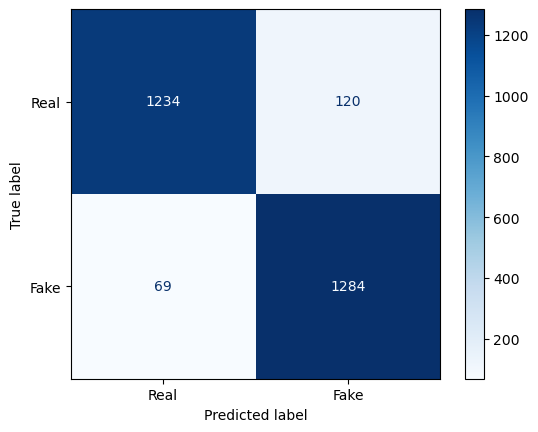

In [5]:
scores = []

scores.append(evaluation(X_test, y_test, et))

accuracy: 0.9227927595123753
recall: 0.926829268292683
precision: 0.9193548387096774
f1 score: 0.923076923076923


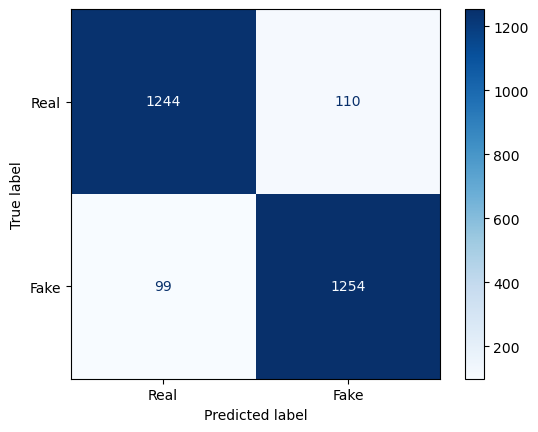

In [6]:
scores.append(evaluation(X_test, y_test, rsvc))

accuracy: 0.9157739194680458
recall: 0.926829268292683
precision: 0.9067245119305857
f1 score: 0.9166666666666666


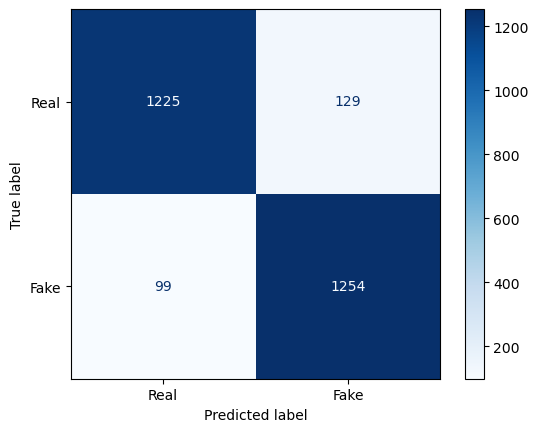

In [7]:
scores.append(evaluation(X_test, y_test, adb))

In [8]:
pd.DataFrame(scores, index = ['Extra Trees', 'Radial SVC', 'AdaBoost'])

,accuracy,recall,precision,f1_score
Extra Trees,0.930181,0.949002,0.914530,0.931447
Radial SVC,0.922793,0.926829,0.919355,0.923077
AdaBoost,0.915774,0.926829,0.906725,0.916667


Even before considering the confusion matrices we can see that our Extra Trees model performs best overall and only struggles a bit with precision where it falls slightly behind the Radial SVC. Adaptive Boosting does not compete in any category, sporting the highest error rates in every metric. Precision measures what proportion of our positive predictions were true positives and seeing that it was the worst metric for each of our models we can surmise that all of our models struggled with false positives. While Extra Trees was our best model overall, it was also the least balanced model. It did a great job discerning which comments were AI generated but had a tendency to flag real comments as AI generated as well. The model that performed the most evenly was RSVC which still tended to slightly more false positives than false negatives but otherwise was about equally accurate at both. Still, there is no reason to consider any model other than Extra Trees as the best model overall. One interesting result to note is that both Adaptive Boosting and RSVC had the same number of false negatives. There's nothing particularly important here but it might suggest that both models ended up splitting the data in similar ways.

To answer our original question we need to understand how these models did across the different subreddits. As a reminder the six subreddits we gathered from were:
- AskReddit
- askscience
- AskHistorians
- explainlikeimfive
- NoStupidQuestions
- DoesAnybodyElse

Our original assumptions were that it would not be equally easy to predict which posts were real across these subreddits and we observed that askscience and AskHistorians in particular had much longer real comments than AI generated ones.

Now let's take a look at model performance across subreddits.

In [9]:
subreddits = X['subreddit'].unique()

# This function will plot the confusion matrices for different subreddits for a given model
def subreddit_confuser(model, predictors, observed, model_name):
    _, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8.5))

    for sub, axis in zip(subreddits, ax.reshape(-1)):
        indices = X_test[X_test['subreddit'] == sub].index

        ConfusionMatrixDisplay.from_estimator(model, predictors.loc[indices], observed.loc[indices], cmap = 'Blues', display_labels = ['Real', 'Fake'], ax = axis)
        axis.set_title(sub)

    plt.suptitle(model_name, fontsize = 20)

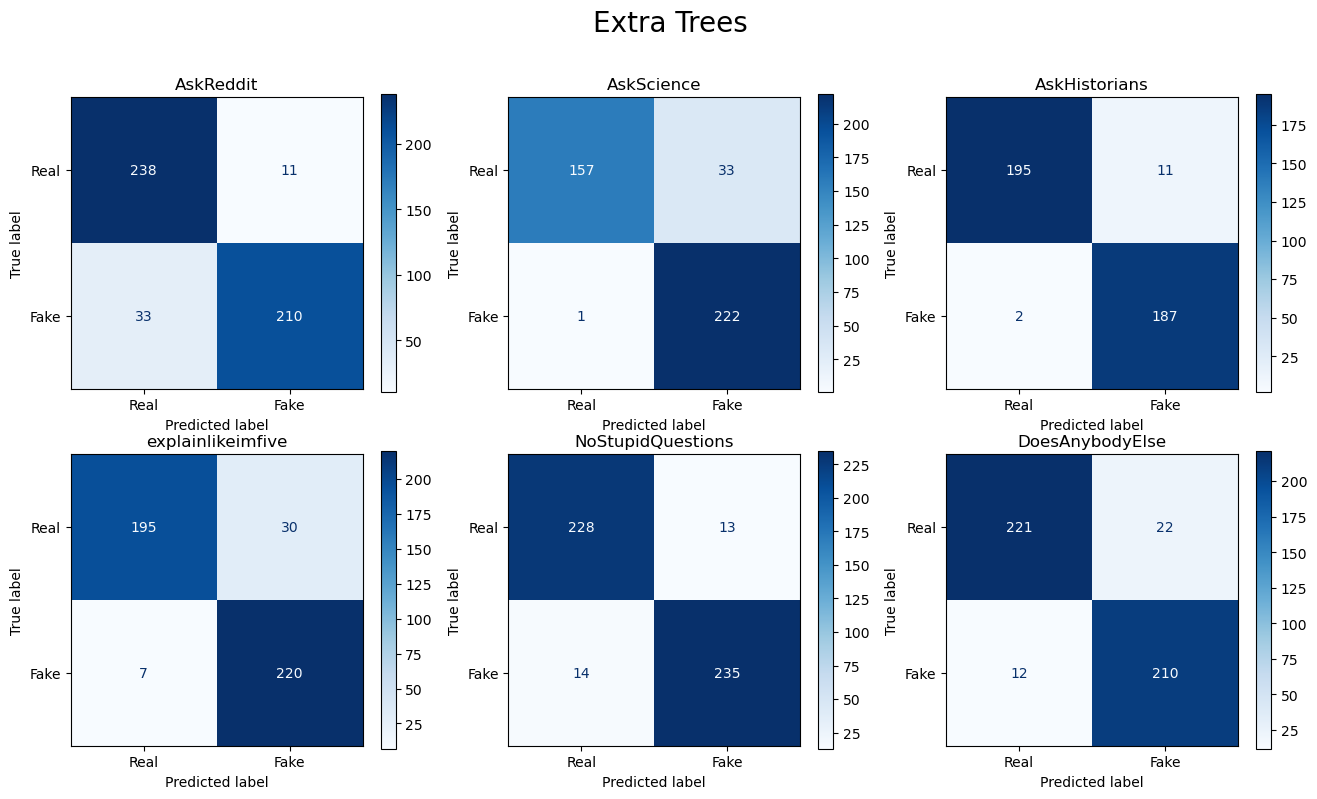

In [10]:
subreddit_confuser(et, X_test, y_test, 'Extra Trees')

Taking a look at each subreddit separately shows us that generally our Extra Trees model is near spot on for AskHistorians but is about the same amount off for the remaining subreddits. Most notably, our false positive and false negative rates are actually different from subreddit to subreddit. AskScience, AskHistorians, explainlikeimfive, and to a lesser extent DoesAnybodyElse all have most incorrect predictions being false positives while AskReddit has the opposite with far more errors being false negatives. NoStupidQuestions is about even for both and thus would have the best f1 score though not by a huge amount.

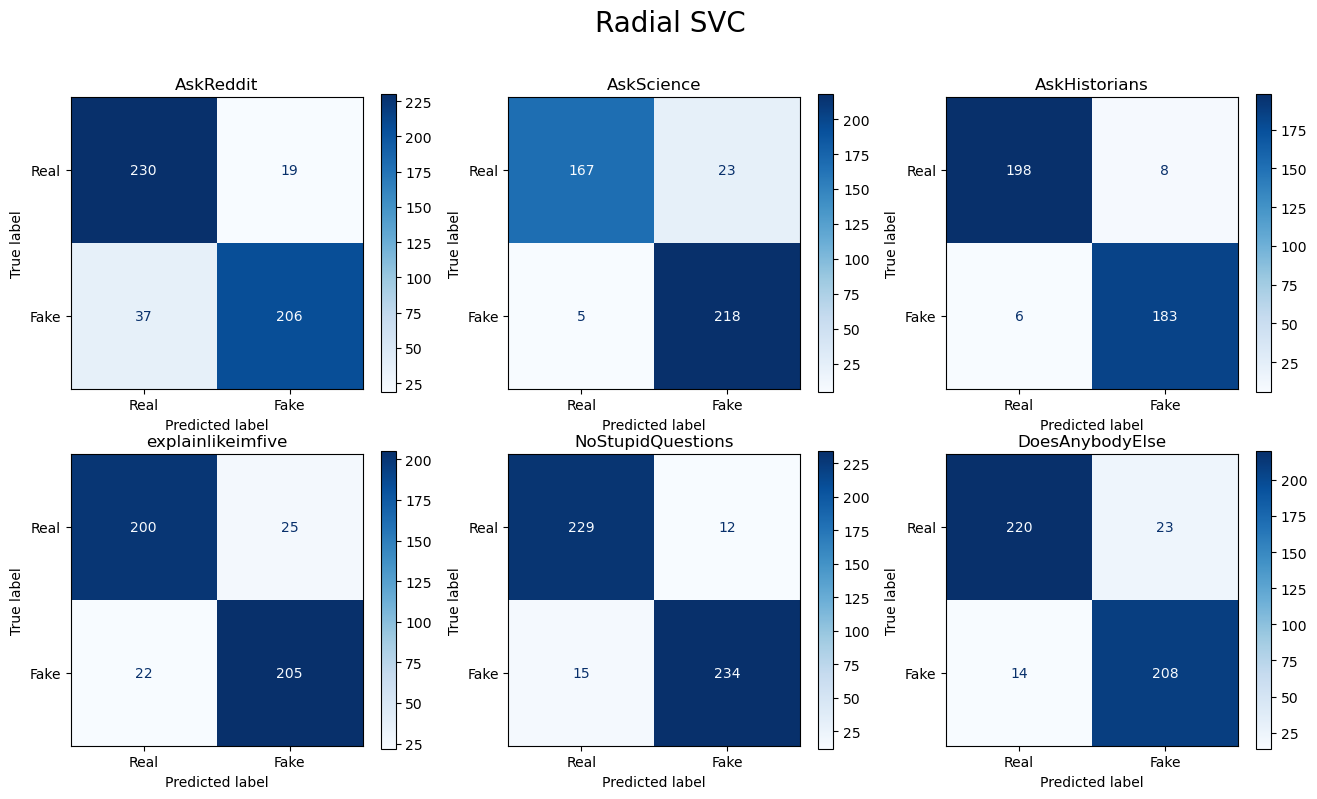

In [11]:
subreddit_confuser(rsvc, X_test, y_test, 'Radial SVC')

We see similar trends generally with the Radial SVC model as we did with the Extra Trees model though not quite as extreme in every case. The largest difference is in AskHistorians where the mistakes are evenly false positive and negatives instead of trending to more false positives. Overall, while this model performed worse it performed a bit more evenly than our Extra Trees model did. Still its hard to justify this model being better given the performance of Extra Trees.

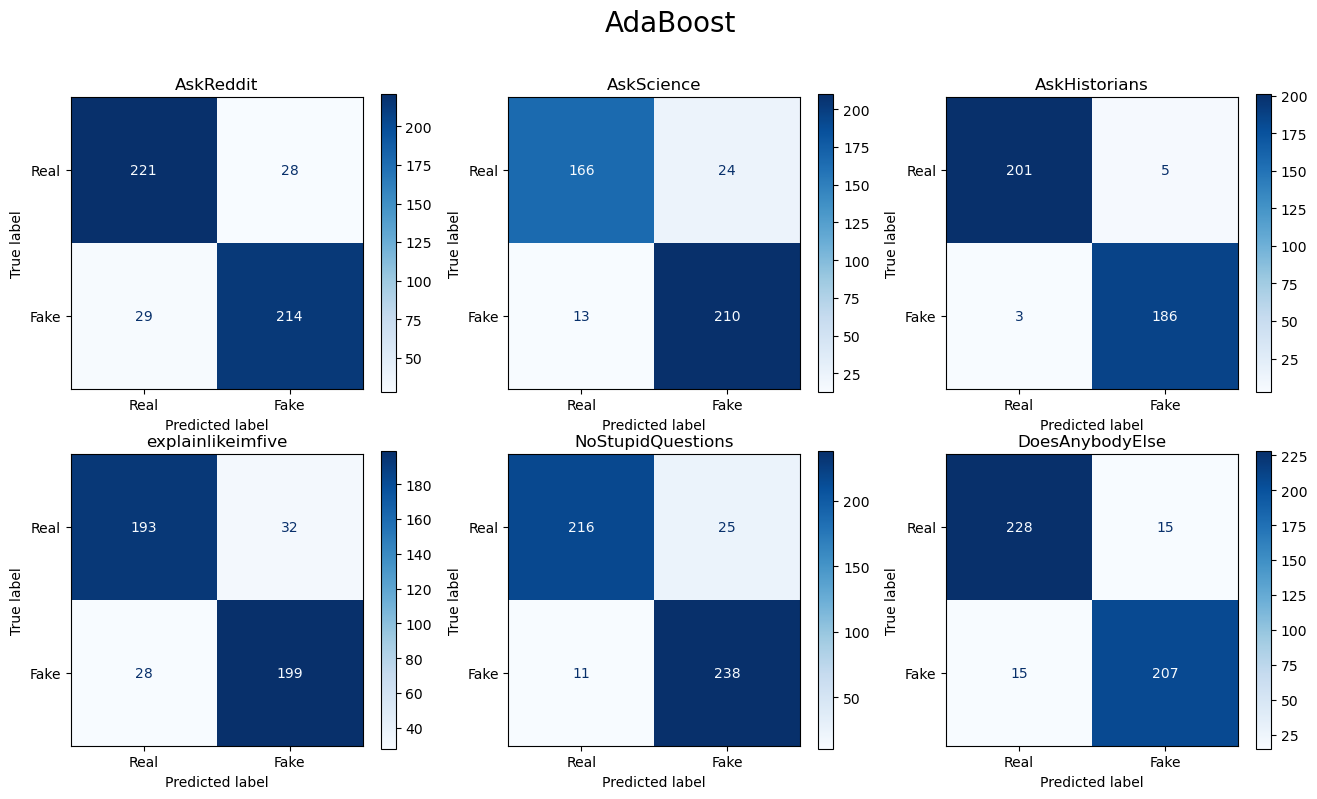

In [12]:
subreddit_confuser(adb, X_test, y_test, 'AdaBoost')

While Adaptive Boosting proved to be the least accurate model overall it also proved to be the most even model, having a closer ratio of false positives to false negatives in each subreddit. The two standouts here are AskScience and NoStupidQuestions which still are 2:1 false positive to false negative but the rest are nearly perfectly even. Additionally, while the last two models were most even on NoStupidQuestions here we see a tendency towards over-sensitivity. Lastly, we see that despite performing a bit worse overall this model performed best on AskHistorians with only 8 missed predictions compared to 13 for our best overall model.